In [31]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import coo_matrix
from plotutil import PlotLayout

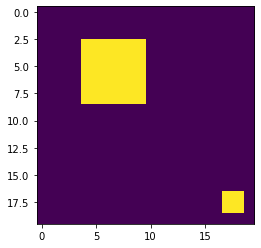

In [64]:
a = 20
x = np.zeros([a, a])
x[3:9, 4:10] = 1
x[17:19, 17:19] = 1
x0 = x.reshape(-1)
plt.imshow(x)

## Constructing Laplacian

需要将 $20 \times 20$ 网格里的每个点全部摊开，得到一个 $400 \times 400$ 的拉普拉斯。

$$
L\phi_i=\lambda_i \phi_i
$$

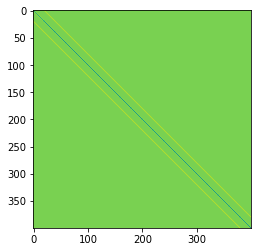

In [65]:
rows = []
cols = []
vals = []
for i in range(a):
    for j in range(a):
        rows.append(i * a + j)
        cols.append(i * a + j)
        if i % a + j % a == 0:
            vals.append(-2)
        elif i % a == 0 or j % a == 0:
            vals.append(-3)
        else:
            vals.append(-4)
        for dir in [(1, 0), (0, 1)]:
            i2 = i + dir[0]
            j2 = j + dir[1] 
            if i2 < a and j2 < a:
                rows.append(i * a + j)
                cols.append(i2 * a + j2)
                vals.append(1)
                rows.append(i2 * a + j2)
                cols.append(i * a + j)
                vals.append(1)

L = coo_matrix((vals, (rows, cols)), shape=[a ** 2, a ** 2], dtype=np.float64)

# eigval, eigvec = eigs(L, k=a ** 2 - 10)
L = L.toarray()
eigval, eigvec = np.linalg.eig(L)
plt.imshow(L)

# Reconstructing initial state

检查一下特征分解是否成功，看看能不能恢复初始状态。

$$
f_0 = \sum_i \alpha_i \phi_i
$$

0.6470731239112267


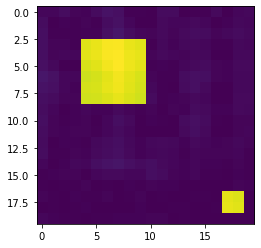

In [66]:
alpha0 = x0 @ eigvec # 400 @ 400 x 6
x1 = (alpha0 * eigvec).sum(-1)
print((x0 - x1).sum())
plt.imshow(np.abs(x1).reshape(a, a))

## Solving the Heat Equation

Solving the PDE,

$$
\frac{\partial f(x, t)}{\partial t} = \frac{\partial^2 f(x, t)}{\partial x^2} \\
f(x, 0) = f_0(x)
$$

we get:

$$
f(x, t) = \sum_i \alpha_i \exp(\lambda_i t) \phi_i(x)
$$

allocating 2 rows x 3 cols for 6 subplots.


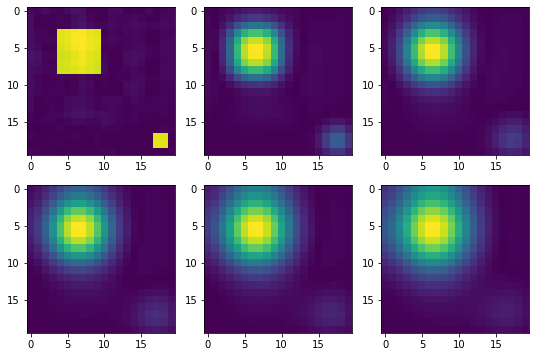

In [70]:
layout = PlotLayout(plt, 6, num_per_row=3, row_width=3, col_width=3)
layout.prepare()

for i in range(6):
    layout.subplot(i)
    xt = (alpha0 * np.exp(eigval * i * 1) * eigvec).sum(-1)
    xt = xt.reshape(a, a)
    plt.imshow(np.abs(xt))

## Caculating the Heat Kernel

Heat kernel $k_t(x, y)$ 指的是到第 t 个时刻为止，累积一共有多少热量从 $y$ 传到 $x$。

定义来自于：
$$
u(x, t) = \int k_t(x, y) u_0(y) dy
$$

解出来是：

$$
k_t(x, y) = \sum_i \exp (-\lambda_i t) \phi_i(x) \phi_i(y)
$$

注意这里的 $x$、$y$ 不是横坐标纵坐标，而是代表区域内的两个点。为了方便，在此我们只取某个固定的 $y$ 来看该点对其他区域（所有 $x$ ）的影响。

allocating 2 rows x 3 cols for 6 subplots.


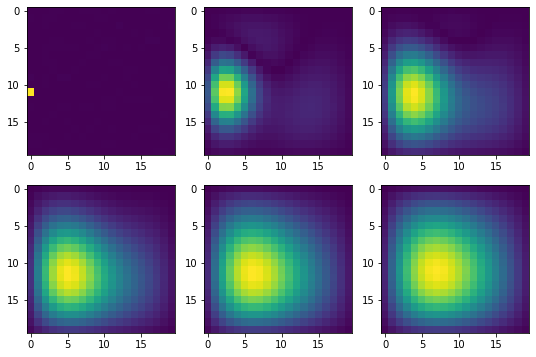

In [74]:
layout = PlotLayout(plt, 6, num_per_row=3, row_width=3, col_width=3)
layout.prepare()

y = (10, 20)
y = y[0] * a + y[1]
for i in range(6):
    layout.subplot(i)
    # 每一列是一个特征向量
    kernel = (
        np.exp(-eigval * i * 5).reshape(1, a ** 2)  # (1, D)
        * eigvec   # (D, D)
        * eigvec[y: y+1, :]   # (1, D) 
    ).sum(1)
    plt.imshow(np.abs(kernel).reshape(a, a))